# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of TPUs assigned: ", len(tf.config.list_logical_devices('TPU')))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Number of TPUs assigned:  8


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

# Load Dataset

In [ ]:
dataset_folder_location = '/content/drive/MyDrive/B.Tech. Final Year Project/Offensive Language Detection/Datasets/m_dataset_21_9/dataset_12_10/'

df_train = pd.read_csv(dataset_folder_location+'train.csv')
df_test = pd.read_csv(dataset_folder_location+'test.csv')
df_val = pd.read_csv(dataset_folder_location+'val.csv')

# Load Dataset Embeddings

In [ ]:
dataset_embeddings_folder_location = '/content/drive/MyDrive/B.Tech. Final Year Project/Offensive Language Detection/Datasets/m_dataset_21_9/dataset_embeddings_12_10/'

df_train_embeddings = np.load(dataset_embeddings_folder_location+'train.npy')
df_test_embeddings = np.load(dataset_embeddings_folder_location+'test.npy')
df_val_embeddings = np.load(dataset_embeddings_folder_location+'val.npy')

In [ ]:
X_train = df_train_embeddings
X_test = df_test_embeddings
X_val = df_val_embeddings
y_train = df_train['hate']
y_test = df_test['hate']
y_val = df_val['hate']

# Binary Classification
Layers
* LSTM
* Dense
* Dropout

In [ ]:
embedding_size = df_train_embeddings.shape[1]

In [ ]:
binary_threshold = 0.4

In [ ]:
with strategy.scope():
    binary_classification_model = tf.keras.Sequential([
        # tf.keras.layers.Bidirectional(
        #     tf.keras.layers.LSTM(embedding_size, return_sequences=True),
        #     name='Bi-LSTM'
        # ),
        tf.keras.layers.LSTM(embedding_size, return_sequences=True, name='LSTM_1', dropout=0.1),
        # tf.keras.layers.LSTM(embedding_size, return_sequences=True, name='LSTM_2'),
        tf.keras.layers.LSTM(embedding_size, name='LSTM_3', dropout=0.1),
        tf.keras.layers.Dense(512, activation='leaky_relu', name='Hidden_Dense_1'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='leaky_relu', name='Hidden_Dense_2'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='leaky_relu', name='Hidden_Dense_3'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid', name='Output'),
    ], name='Binary_Classification_Model_LSTM')

    binary_classification_model.build((None, embedding_size, 1))
    binary_classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=binary_threshold)
        ])
binary_classification_model.summary()

Model: "Binary_Classification_Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 256, 256)          264192    
                                                                 
 LSTM_3 (LSTM)               (None, 256)               525312    
                                                                 
 Hidden_Dense_1 (Dense)      (None, 512)               131584    
                                                                 
 dropout_69 (Dropout)        (None, 512)               0         
                                                                 
 Hidden_Dense_2 (Dense)      (None, 256)               131328    
                                                                 
 dropout_70 (Dropout)        (None, 256)               0         
                                                                 
 Hidden_Dense_3 (Dense)      (None

In [ ]:
epochs=5 # 100
batch_size=128
history_of_model_train = binary_classification_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs, batch_size=batch_size
)

Epoch 1/5
495/495 [==============================] - 39s 80ms/step - loss: 0.2990 - binary_accuracy: 0.8663 - val_loss: 0.6047 - val_binary_accuracy: 0.7670
Epoch 2/5
495/495 [==============================] - 39s 79ms/step - loss: 0.2972 - binary_accuracy: 0.8692 - val_loss: 0.6281 - val_binary_accuracy: 0.7733
Epoch 3/5
495/495 [==============================] - 39s 79ms/step - loss: 0.2912 - binary_accuracy: 0.8729 - val_loss: 0.6010 - val_binary_accuracy: 0.7620
Epoch 4/5
495/495 [==============================] - 39s 79ms/step - loss: 0.2950 - binary_accuracy: 0.8702 - val_loss: 0.6022 - val_binary_accuracy: 0.7687
Epoch 5/5
495/495 [==============================] - 39s 79ms/step - loss: 0.2902 - binary_accuracy: 0.8736 - val_loss: 0.6872 - val_binary_accuracy: 0.7629


In [ ]:
y_test_pred = binary_classification_model.predict(X_test)

565/565 [==============================] - 12s 20ms/step


Optimal threshold: 0.25191456
Optimal F1-score: 0.7113664633062844


Text(0.5, 1.0, 'Precision-Recall Curve')

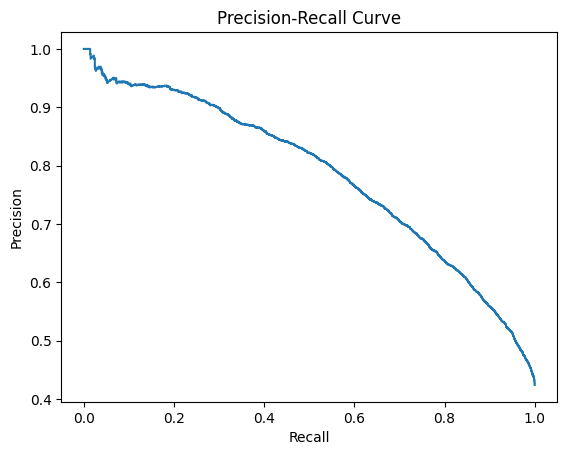

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)

f1_scores = 2 * recall * precision / (recall + precision)

# Find the index of the maximum F1-score
max_index = np.argmax(f1_scores)

optimal_threshold = thresholds[max_index]
optimal_f1_score = f1_scores[max_index]
print('Optimal threshold:', optimal_threshold)
print('Optimal F1-score:', optimal_f1_score)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [ ]:
def pred_of_y_labelling(y):
    return (1 if y[0] > binary_threshold else 0)

y_pred = np.apply_along_axis(pred_of_y_labelling, 1, y_test_pred)

Accuracy Score:  0.768941280646411
     Precision:  0.7107298211696472
        Recall:  0.767584496933316
      F1-Score:  0.7380638684986512

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79     10406
           1       0.71      0.77      0.74      7663

    accuracy                           0.77     18069
   macro avg       0.76      0.77      0.77     18069
weighted avg       0.77      0.77      0.77     18069



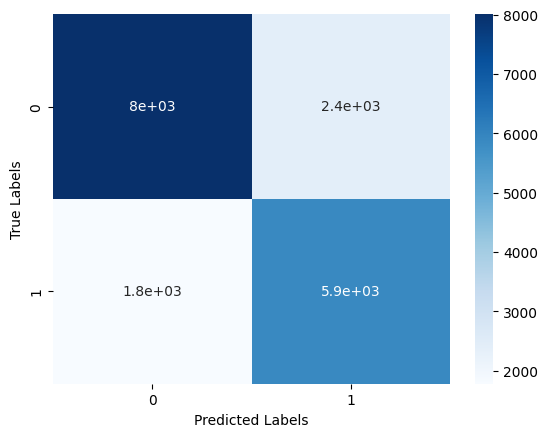

In [ ]:
confusion_matrix_sklearn = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_sklearn, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred))
print('     Precision: ', metrics.precision_score(y_test, y_pred))
print('        Recall: ', metrics.recall_score(y_test, y_pred))
print('      F1-Score: ', metrics.f1_score(y_test, y_pred))
print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

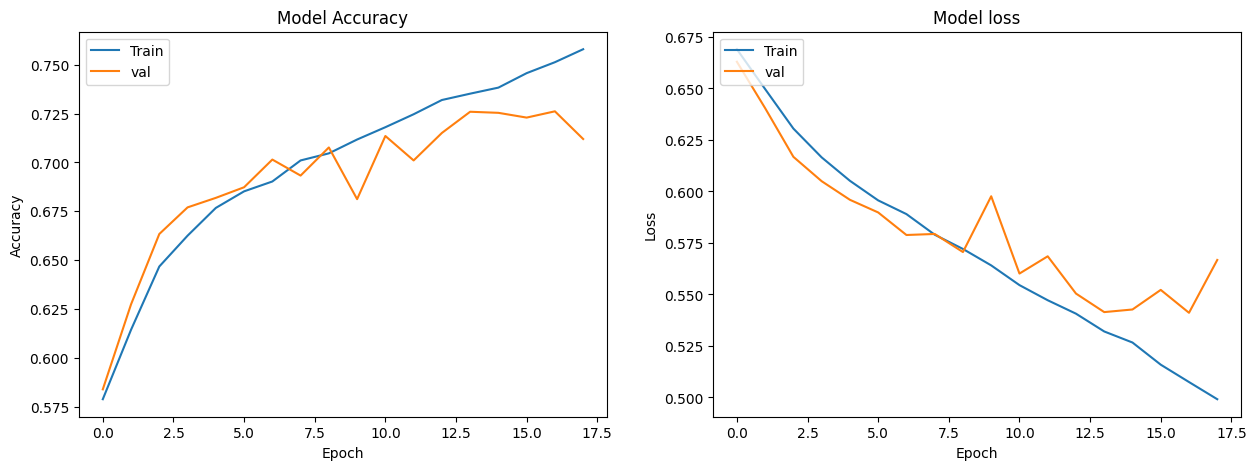

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy value:
axis[0].plot(history_of_model_train.history['binary_accuracy'])
axis[0].plot(history_of_model_train.history['val_binary_accuracy'])
axis[0].set_title('Model Accuracy')
axis[0].set_ylabel('Accuracy')
axis[0].set_xlabel('Epoch')
axis[0].legend(['Train', 'val'], loc='upper left')

# Plot training 8 validation loss values
axis[1].plot(history_of_model_train.history['loss'])
axis[1].plot(history_of_model_train.history['val_loss'])
axis[1].set_title('Model loss')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend(['Train', 'val'], loc='upper left')

# Save Trained Model

In [ ]:
models_save_location = '/content/drive/MyDrive/B.Tech. Final Year Project/Offensive Language Detection/Data Processing Codes/Implementations/BanglaBERT Models/'
# model_name = 'm_data_21_9_banglabert_'+str(epochs)
model_name = 'm_data_21_9_banglabert_100_4_77_77'
binary_classification_model.save(models_save_location+model_name+'.keras')